### LASSO parameter range experiments

We want to see whether smaller models (i.e. models with fewer nonzero features) tend to generalize to new cancer types better than larger ones; this script compares/visualizes those results.

In [1]:
import os
import itertools as it
from math import ceil

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'cancer_type_range'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

# gene/cancer type to plot results for
plot_gene = 'CDKN2A'
plot_cancer_type = 'LGG'

# performance metric: 'aupr' or 'auroc'
metric = 'aupr'

output_plots = True

# toggle this in papermill script to generate results for all genes
figshare = False

In [2]:
if figshare:
    output_plots_dir = os.path.join(
        cfg.repo_root, '02_cancer_type_classification', 'generalization_plots', 'figshare'
    )
else:
    output_plots_dir = os.path.join(
        cfg.repo_root, '02_cancer_type_classification', 'generalization_plots'
    )

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir, gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.lasso_param = nz_coefs_df.lasso_param.astype(float)
nz_coefs_df = nz_coefs_df[(nz_coefs_df.gene == plot_gene) &
                          (nz_coefs_df.cancer_type == plot_cancer_type)].copy()
nz_coefs_df.head()

,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,CDKN2A,LGG,1.000000e+07,42,0,15370
1,CDKN2A,LGG,1.000000e+07,42,1,15370
2,CDKN2A,LGG,1.000000e+07,42,2,15370
3,CDKN2A,LGG,1.000000e+07,42,3,15370
76,CDKN2A,LGG,3.160000e-03,1,0,1


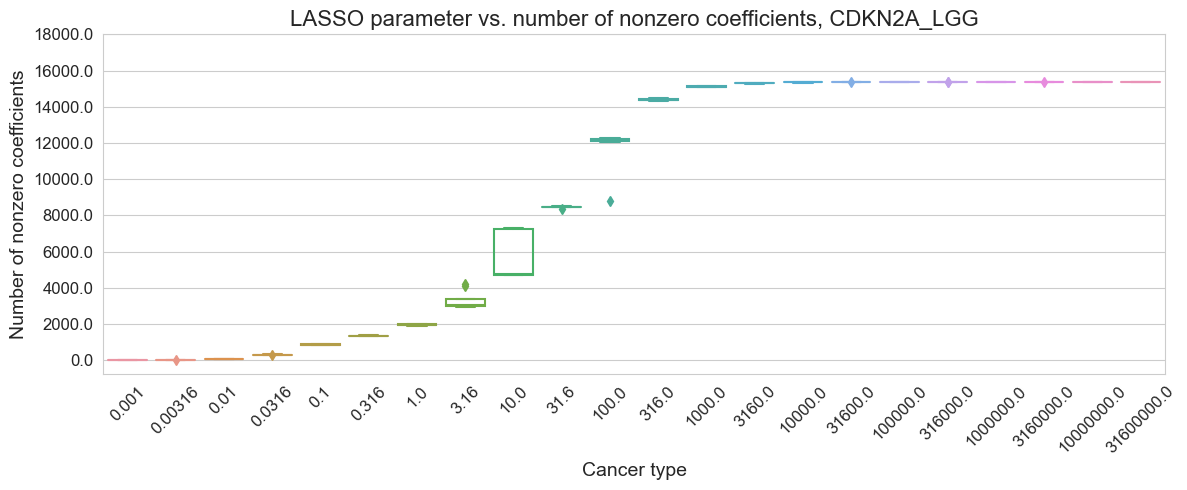

In [4]:
sns.set({'figure.figsize': (12, 5)})
sns.set_style('whitegrid')

sns.boxplot(
    data=nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='lasso_param', y='nz_coefs'
)

# color the boxplot lines/edges rather than the box fill
# this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
# https://stackoverflow.com/a/72333641
ax = plt.gca()
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers

plt.title(f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}_{plot_cancer_type}',
          size=16)
plt.xlabel('Cancer type', size=14)
plt.ylabel('Number of nonzero coefficients', size=14)
ax.tick_params(axis='x', rotation=45)
_, xlabels = plt.xticks()
_ = ax.set_xticklabels(xlabels, size=12)
ax.set_yticks(ax.get_yticks()[1:])
_ = ax.set_yticklabels(ax.get_yticks(), size=12)
plt.tight_layout()

if output_plots:
    os.makedirs(output_plots_dir, exist_ok=True)
    plt.savefig(os.path.join(output_plots_dir, f'{plot_gene}_{plot_cancer_type}_coefs.png'),
                dpi=200, bbox_inches='tight')

### Get performance information for each lasso penalty

In [5]:
perf_df = au.load_prediction_results_lasso_range(results_dir,
                                                 training_dataset,
                                                 gene=plot_gene)
perf_df = perf_df[(perf_df.gene == plot_gene) &
                  (perf_df.holdout_cancer_type == plot_cancer_type)].copy()
perf_df.lasso_param = perf_df.lasso_param.astype(float)
perf_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,1.00000,1.00000,CDKN2A,LGG,signal,42,train,0,all_other_cancers,100.0
1,0.64881,0.30228,CDKN2A,LGG,signal,42,test,0,all_other_cancers,100.0
2,0.78452,0.60398,CDKN2A,LGG,signal,42,cv,0,all_other_cancers,100.0
3,1.00000,1.00000,CDKN2A,LGG,signal,42,train,1,all_other_cancers,100.0
4,0.56953,0.17053,CDKN2A,LGG,signal,42,test,1,all_other_cancers,100.0


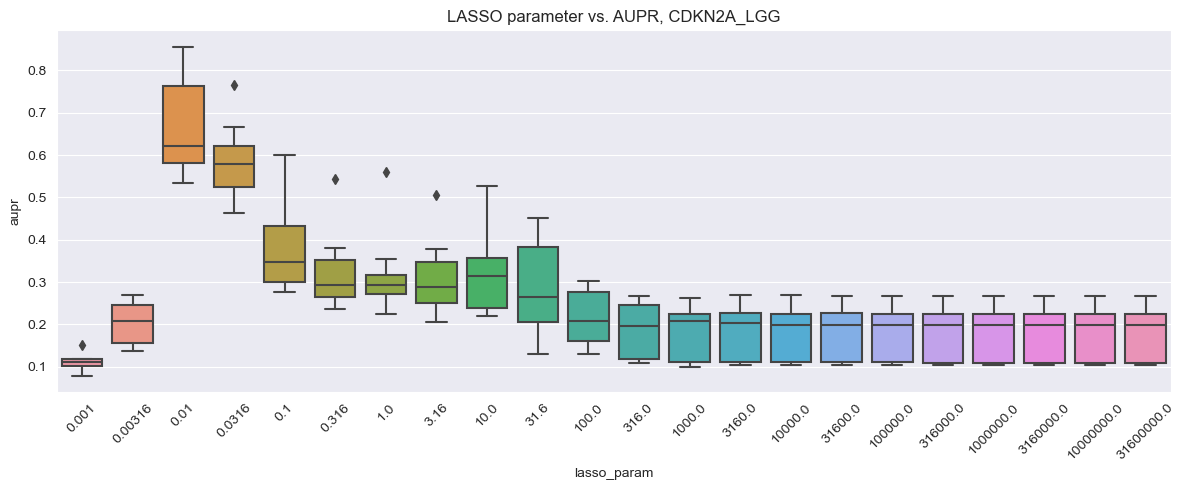

In [6]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=(
        perf_df[(perf_df.signal == 'signal') &
                (perf_df.data_type == 'test')]
          .sort_values(by=['holdout_cancer_type', 'lasso_param'])
    ), x='lasso_param', y=metric
)
plt.gca().tick_params(axis='x', rotation=45)
plt.title(f'LASSO parameter vs. {metric.upper()}, {plot_gene}_{plot_cancer_type}')
plt.tight_layout()

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'{plot_gene}_{plot_cancer_type}_lasso_boxes.png'),
                dpi=200, bbox_inches='tight')

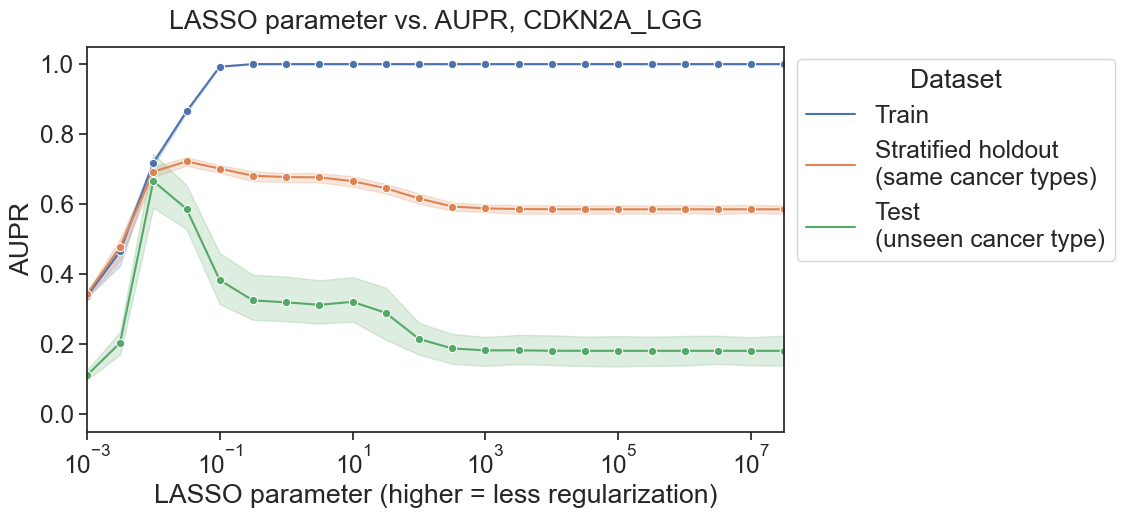

In [7]:
# plot LASSO parameter vs. AUPR, for all 3 datasets
# "train" = data used to train model
# "cv" = validation set
# "test" = held-out cancer type
sns.set({'figure.figsize': (9, 5)})
sns.set_style('ticks')

plot_df = (
    perf_df[(perf_df.signal == 'signal')]
      .sort_values(by=['lasso_param'])
      .reset_index(drop=True)
)
plot_df.lasso_param = plot_df.lasso_param.astype(float)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.lineplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o',
    )
    g.set(xscale='log', xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)), ylim=(-0.05, 1.05))
    g.set_xlabel('LASSO parameter (higher = less regularization)')
    g.set_ylabel(f'{metric.upper()}')
    
    ax = plt.gca()
    legend_handles, _ = ax.get_legend_handles_labels()
    dataset_labels = ['Train', 'Stratified holdout \n(same cancer types)', 'Test \n(unseen cancer type)']
    ax.legend(legend_handles, dataset_labels, title='Dataset')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    
    plt.title(f'LASSO parameter vs. {metric.upper()}, {plot_gene}_{plot_cancer_type}', y=1.025)
    
if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'{plot_gene}_{plot_cancer_type}_parameter_vs_perf.svg'), bbox_inches='tight')

### Visualize LASSO model selection for the given gene

We want to use two different strategies to pick the "best" LASSO parameter:

1. Choose the top 25% of LASSO parameters based on validation set AUPR, then take the smallest model (least nonzero coefficients) in that set. This is the "smallest good" model approach, that assumes that smaller models will generalize better (conditional on decent validation performance).
2. Choose the top LASSO parameter based solely on validation set AUPR, without considering model size. This is the "best" approach.

We'll plot the results of both strategies (which sometimes select the same parameter, but usually they're different) for the given gene below.

In [8]:
def get_top_and_smallest_lasso_params(cancer_type, top_proportion=0.25):
    top_df = (
        perf_df[(perf_df.data_type == 'cv') &
                (perf_df.signal == 'signal') &
                (perf_df.holdout_cancer_type == cancer_type)]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
    )
    top_df.index = top_df.index.astype(float)
    top_df['aupr_rank'] = top_df.mean_aupr.rank(ascending=False)
    rank_cutoff = ceil(perf_df.lasso_param.unique().shape[0] * top_proportion)
    params_above_cutoff = top_df.loc[top_df.aupr_rank <= rank_cutoff, :].index
    
    # get parameter with best validation performance
    top_lasso_param = params_above_cutoff[0]

    # get parameter in top 5 validation performance with least nonzero coefficients
    smallest_lasso_param = (
        nz_coefs_df[(nz_coefs_df.cancer_type == cancer_type) &
                    (nz_coefs_df.lasso_param.isin(params_above_cutoff))]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .sort_values(by='nz_coefs', ascending=True)
    ).index[0]
    
    compare_df = top_df.loc[
        [smallest_lasso_param, top_lasso_param], :
    ]
    compare_df['cancer_type'] = cancer_type
    compare_df['desc'] = ['smallest', 'best']
    return compare_df

In [9]:
compare_df = get_top_and_smallest_lasso_params(plot_cancer_type)
compare_df.head(5)

,mean_auroc,mean_aupr,aupr_rank,cancer_type,desc
lasso_param,,,,,
0.0100,0.829008,0.692629,3.0,LGG,smallest
0.0316,0.850514,0.722051,1.0,LGG,best


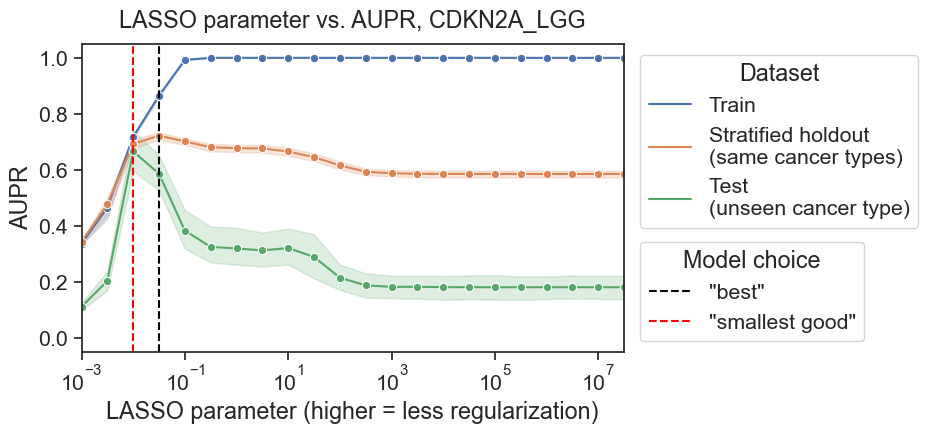

In [10]:
# same plot as before but with the "best"/"smallest" parameters marked
sns.set({'figure.figsize': (7, 4)})
sns.set_style('ticks')

plot_df = (
    perf_df[(perf_df.signal == 'signal')]
      .sort_values(by=['lasso_param'])
      .reset_index(drop=True)
)
plot_df.lasso_param = plot_df.lasso_param.astype(float)

with sns.plotting_context('notebook', font_scale=1.4):
    g = sns.lineplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o'
    )
    g.set(xscale='log', xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)), ylim=(-0.05, 1.05))
    g.set_xlabel(f'LASSO parameter (higher = less regularization)')
    g.set_ylabel(f'{metric.upper()}')
    
    ax = plt.gca()
    ax.axvline(x=compare_df[(compare_df.desc == 'best')].index.values[0],
               color='black', linestyle='--')
    ax.axvline(x=compare_df[(compare_df.desc == 'smallest')].index.values[0],
               color='red', linestyle='--')
        
    # create custom legend for best models lines
    legend_handles = [
        Line2D([0], [0], color='black', linestyle='--'),
        Line2D([0], [0], color='red', linestyle='--'),
    ]
    legend_labels = ['"best"', '"smallest good"']
    l = ax.legend(legend_handles, legend_labels, title='Model choice',
                  loc='lower left', bbox_to_anchor=(1.01, 0))
    ax.add_artist(l)
    
    legend_handles, _ = ax.get_legend_handles_labels()
    ax.legend(legend_handles, dataset_labels, title='Dataset')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1.01, 1))
    plt.title(f'LASSO parameter vs. {metric.upper()}, {plot_gene}_{plot_cancer_type}', y=1.025)
    
if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'{plot_gene}_{plot_cancer_type}_best_vs_smallest.svg'), bbox_inches='tight')